In [1]:
import sys
import os
import re
import time
import numpy as np
import datetime
from typing import List, Dict, Any, Tuple
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain, SequentialChain, SimpleSequentialChain
from langchain.memory import ConversationBufferWindowMemory, FileChatMessageHistory, ConversationSummaryBufferMemory
from langchain_openai import OpenAI
from langchain.agents import AgentType, initialize_agent, Tool
from langchain.agents import AgentExecutor
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.schema import Document
from langchain.vectorstores import FAISS
from dateutil import parser
from dateutil.relativedelta import relativedelta
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [2]:
from dotenv import load_dotenv
import os

load_dotenv('C:\\Users\\TERENTI\\Desktop\\UNI\\LLM\\api_key.env')

api_key = os.getenv('API_KEY')


In [3]:
model = ChatGoogleGenerativeAI(
    google_api_key=api_key,
    model="gemini-2.0-flash",
    temperature=0.0,
)

embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2",
    model_kwargs={'device': 'cpu'}
)

C:\Users\TERENTI\AppData\Local\Temp\ipykernel_6624\4077689756.py:7: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(
c:\Users\TERENTI\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
TICKET_FILE_NAME = "tickets.txt"
TICKET_FILE_PATH = "./data/tickets.txt"

class RAGDocStore:
    def __init__(self, embeddings):
        self.embeddings = embeddings
        self.ticket_store = None
        self.policy_store = None
        self.information_store = None
        self.all_tickets = []
        
    def add_ticket(self, content):
        self.all_tickets.append(content)
        documents = [Document(page_content=content, metadata={"type": "ticket"})]
        
        if self.ticket_store is None:
            self.ticket_store = FAISS.from_documents(documents, self.embeddings)
        else:
            self.ticket_store.add_documents(documents)

    def add_information_documents(self, documents):
        if self.information_store is None:
            self.information_store = FAISS.from_documents(documents, self.embeddings)
        else:
            self.information_store.add_documents(documents)

    def add_policy_documents(self, documents):
        if self.policy_store is None:
            self.policy_store = FAISS.from_documents(documents, self.embeddings)
        else:
            self.policy_store.add_documents(documents)
    
    def search_tickets(self, query, threshold=1.35):
        if not self.ticket_store or not self.all_tickets:
            return []

        k_candidate = len(self.all_tickets) if self.all_tickets else 100
        results_with_scores = self.ticket_store.similarity_search_with_score(query, k=k_candidate)
        
        filtered_results = []
        
        for doc, score in results_with_scores:
            if score < threshold: 
                filtered_results.append(doc.page_content)

        return filtered_results
    
    def search_information(self, query, k=5):
        if not self.information_store:
            return []

        docs = self.information_store.similarity_search(query, k=k)
        return [doc.page_content for doc in docs]
    
    def search_policy(self, query, k=5):
        if not self.policy_store:
            return []

        docs = self.policy_store.similarity_search(query, k=k)
        return [doc.page_content for doc in docs]
        
    def search_all(self, query):
        ticket_results = self.search_tickets(query)
        information_results = self.search_information(query)
        policy_results = self.search_policy(query)
        all_results = ticket_results + information_results + policy_results
        return all_results

    def update_ticket(self, old_ticket, new_ticket):
        try:
            if old_ticket in self.all_tickets:
                index = self.all_tickets.index(old_ticket)
                self.all_tickets[index] = new_ticket
                
                if self.ticket_store:
                    documents = [Document(page_content=ticket, metadata={"type": "ticket"}) 
                                for ticket in self.all_tickets]
                    self.ticket_store = FAISS.from_documents(documents, self.embeddings)
                
                return True
            return False
        except Exception as e:
            print(f"Error updating ticket: {e}")
            return False

def setup_docstore(ticket_file_name, ticket_file_path):
    if not os.path.exists("data"):
        os.makedirs("data")
    
    docstore = RAGDocStore(embeddings)
    
    for filename in [ticket_file_name, "policies.txt", "product_data.txt"]:
        file_path = os.path.join("data", filename)
        if not os.path.exists(file_path):
            with open(file_path, "w") as f:
                pass
    
    try:
        with open(ticket_file_path, "r") as f:
            for line in f:
                line = line.strip()
                if line:
                    docstore.add_ticket(line)
    except Exception as e:
        print(f"Error loading tickets: {e}")

    try:
        pdata_file_path = os.path.join("data", "product_data.txt")
        if os.path.getsize(pdata_file_path) > 0:
            loader = TextLoader(pdata_file_path)
            docs = loader.load()
            
            text_splitter = RecursiveCharacterTextSplitter(
                chunk_size=1000,
                chunk_overlap=200,
                length_function=len,
            )

            chunks = text_splitter.split_documents(docs)
            
            docstore.add_information_documents(chunks)
            print("Product information loaded into docstore.")
        else:
            print("Product information file is empty. Skipping loading.")
    except Exception as e:
        print(f"Error loading product information: {e}")

    try:
        policies_file_path = os.path.join("data", "policies.txt")
        if os.path.getsize(policies_file_path) > 0:
            loader = TextLoader(policies_file_path)
            docs = loader.load()
            
            text_splitter = RecursiveCharacterTextSplitter(
                chunk_size=1000,
                chunk_overlap=200,
                length_function=len,
            )

            chunks = text_splitter.split_documents(docs)
            
            docstore.add_policy_documents(chunks)
            print("Policies information loaded into docstore.")
        else:
            print("Policies information file is empty. Skipping loading.")
    except Exception as e:
        print(f"Error loading policies information: {e}")
    

    return docstore

In [5]:
docstore = setup_docstore(TICKET_FILE_NAME, TICKET_FILE_PATH)

Error loading product information: Error loading data\product_data.txt
Error loading policies information: Error loading data\policies.txt


In [6]:
class TicketTool:
    def __init__(self, docstore, ticket_file_path):
        self.docstore = docstore
        self.ticket_file_path = ticket_file_path
        self.next_ticket_id = self._get_next_ticket_id()

    def _get_next_ticket_id(self):
        try:
            with open(self.ticket_file_path, "r") as f:
                tickets = f.read().splitlines()
            
            max_id = 10000
            
            for ticket in tickets:
                match = re.search(r"Ticket #(\d+):", ticket)
                if match:
                    ticket_id = int(match.group(1))
                    max_id = max(max_id, ticket_id)
            
            return max_id + 1
            
        except FileNotFoundError:
            return 10001
        except Exception as e:
            print(f"Error reading tickets file: {e}")
            return 10001
    
    def create_ticket(self, issue_description):
        issue_description = issue_description.strip()
        if len(issue_description) > 100:
            issue_description = issue_description[:100] + "..."
        
        ticket_id = self.next_ticket_id
        self.next_ticket_id += 1
        status = "New"
        created_date = datetime.datetime.now().strftime("%Y-%m-%d")
        ticket = f"Ticket #{ticket_id}: {issue_description} - Status: {status} - Created: {created_date}"
        
        with open(self.ticket_file_path, "a") as f:
            f.write("\n" + ticket)
        
        self.docstore.add_ticket(ticket)
        
        return f"Created ticket #{ticket_id}. Status: {status}"

    def update_ticket_status(self, ticket_info):
        try:
            parts = ticket_info.strip().split(' ', 1)
            
            if len(parts) != 2:
                return "Please provide both ticket ID and new status (e.g., '10001 Resolved')"
                
            ticket_id = parts[0].strip()
            ticket_id = ticket_id.replace("'", "").replace('"', '').replace('#', '').strip()
                
            if not ticket_id.isdigit():
                return f"Invalid ticket ID: {ticket_id}. Please provide a numeric ticket ID."
                
            new_status = parts[1].strip()
            
            ticket_query = f"Ticket #{ticket_id}"
            matching_tickets = self.docstore.search_tickets(ticket_query)
            
            target_ticket = None
            for ticket in matching_tickets:
                if f"Ticket #{ticket_id}:" in ticket:
                    target_ticket = ticket
                    break
            
            if not target_ticket:
                return f"Ticket #{ticket_id} not found."
            
            current_status_match = re.search(r"Status: ([^-]+)", target_ticket)
            if not current_status_match:
                return f"Could not parse status in ticket: {target_ticket}"
                
            current_status = current_status_match.group(1).strip()
            updated_ticket = target_ticket.replace(f"Status: {current_status}", f"Status: {new_status}")
            
            update_successful = self.docstore.update_ticket(target_ticket, updated_ticket)
            
            if not update_successful:
                return f"Failed to update ticket in document store."
                
            with open(self.ticket_file_path, "r") as f:
                tickets = f.read().splitlines()
                
            for i, ticket in enumerate(tickets):
                if f"Ticket #{ticket_id}:" in ticket:
                    tickets[i] = updated_ticket
                    break
                    
            with open(self.ticket_file_path, "w") as f:
                f.write("\n".join(tickets))
                
            return f"Updated ticket #{ticket_id} status from '{current_status}' to '{new_status}'."
            
        except Exception as e:
            return f"Error updating ticket status: {str(e)}"
        
    def query_ticket_id(self, ticket_id):
        if not ticket_id.isdigit():
            return f"Error: Invalid ticket ID '{ticket_id}'. Please provide a numeric ticket ID (e.g., '10001')."

        for ticket_str in self.docstore.all_tickets:
            if f"Ticket #{ticket_id}:" in ticket_str:
                return ticket_str

        return f"Ticket #{ticket_id} not found in the system."
    
    def query_tickets_info(self, query):
        results = self.docstore.search_tickets(query)
        
        if not results:
            return "No matching tickets found."
        
        return "Found the following relevant tickets:\n" + "\n".join(results)
    
    def query_tickets_date(self, date_range_str):
        try:
            from_date_str, to_date_str = date_range_str.split(' ')
            from_date = datetime.datetime.strptime(from_date_str, "%Y-%m-%d").date()
            to_date = datetime.datetime.strptime(to_date_str, "%Y-%m-%d").date()
        except ValueError:
            return "Error: Invalid date format. Please provide dates in 'YYYY-MM-DD YYYY-MM-DD' format (e.g., '2024-05-01 2024-05-31')."

        if from_date > to_date:
            return "Error: 'from' date cannot be after 'to' date."

        matching_tickets = []
        for ticket in self.docstore.all_tickets:
            match = re.search(r"Created: (\d{4}-\d{2}-\d{2})", ticket)
            if match:
                ticket_date_str = match.group(1)
                try:
                    ticket_date = datetime.datetime.strptime(ticket_date_str, "%Y-%m-%d").date()
                    if from_date <= ticket_date <= to_date:
                        matching_tickets.append(ticket)
                except ValueError:
                    continue
        
        if not matching_tickets:
            return f"No tickets found created between {from_date_str} and {to_date_str}."
        
        return f"Here are the tickets created between {from_date_str} and {to_date_str}:\n" + "\n".join(matching_tickets)

class ContextTool:
    def __init__(self, docstore):
        self.docstore = docstore
    
    def get_context(self, query):
        results = self.docstore.search_all(query)
        
        if not results:
            return "No relevant information found."
        
        return "Here's relevant information that might help:\n" + "\n".join(results)

class DateTool:    
    def get_current_date(self, _=""):
        return datetime.datetime.now().strftime("%Y-%m-%d")

In [7]:
date_tool = DateTool()
ticket_tool = TicketTool(docstore, TICKET_FILE_PATH)
context_tool = ContextTool(docstore)

In [8]:
def hallucination_detection(input_string):
    try:
        parts = input_string.split(" ||| ")
        if len(parts) != 2:
            return "ERROR: Invalid input format. Expected 'ANSWER: [answer] ||| QUERY: [query]'."
        
        initial_answer_raw = parts[0]
        query_raw = parts[1]
        
        if not initial_answer_raw.startswith("ANSWER: ") or not query_raw.startswith("QUERY: "):
            return "ERROR: Invalid input prefixes. Expected 'ANSWER: ' and 'QUERY: '."
            
        initial_answer = initial_answer_raw[len("ANSWER: "):].strip()
        original_query = query_raw[len("QUERY: "):].strip()
        
        verification_prompt = PromptTemplate(
            input_variables=["initial_answer", "original_query"],
            template="""You are an expert assistant evaluating an 'Answer' against an 'Original Query'.
            Your task is to determine if the 'Answer' *logically fulfills* the 'Original Query's request for information or interaction, based *only* on the provided text.

            Answer: {initial_answer}
                        
            Original Query: {original_query}
            
            **Evaluation Rules Based on Query Type:**

            1.  **For Temporal/Data Retrieval Queries (e.g., asking for dates, tickets, specific facts):**
                If the 'Original Query' uses relative time expressions (e.g., "now", "last month", "yesterday", "last week"), assume that a **prior, external step has already correctly translated these into specific absolute dates.** Your role is NOT to verify if these absolute dates (e.g., '2025-06-18') genuinely represent 'now' or 'last month' in the real world. Your sole responsibility is to check if the 'Answer' *consistently uses and presents information* that logically corresponds to such a correct date translation. Assume the absolute dates presented in the 'Answer' are the correct interpretation of the relative terms in the 'Original Query'.

            2.  **For All Other Queries (including greetings, social interactions, general questions, or non-data requests):**
                Evaluate if the 'Answer' is a direct, relevant, and appropriate response to the 'Original Query'.
                * An **appropriate response to a greeting** (e.g., "hello", "hi") includes a reciprocal greeting and/or an offer of assistance.
                * An appropriate response to a general question provides a direct and relevant answer.

            Does the 'Answer' provide information or interaction that directly and relevantly addresses the 'Original Query's main request, following the specific rules above for its query type?

            Instructions:
            1.  If the 'Answer' fully and accurately addresses the 'Original Query' (following the specific rules for temporal/data queries OR the general relevance/appropriateness rules for other queries), respond with "YES".
            2.  If the 'Answer' provides irrelevant information, completely misses the point of the 'Original Query', is factually incorrect (for data queries), or inappropriate/nonsensical (for social/general queries), respond with "NO" followed by a brief, specific reason.
            
            Evaluation:"""
        )
        
        verification_chain = LLMChain(llm=model, prompt=verification_prompt)
        result = verification_chain.run(
            initial_answer=initial_answer,
            original_query=original_query
        )
        return result.strip()
    except Exception as e:
        return f"ERROR: An internal error occurred during hallucination detection: {e}"

tools = [
    Tool(
        name="CheckCurrentDate",
        func=date_tool.get_current_date,
        description="Checks today's date. Returns current date in YYYY-MM-DD format. Input can be empty."
    ),
    Tool(
        name="CreateTicket",
        func=ticket_tool.create_ticket,
        description="Create a new support ticket. Input should be a description of the issue."
    ),
    Tool(
        name="UpdateTicketStatus",
        func=ticket_tool.update_ticket_status,
        description="Update the status of an existing ticket. Input should be ticket ID followed by new status (e.g., '1001 Resolved'). Possible values of new_status are: Resolved, New, Pending, Investigating."
    ),
    Tool(
        name="FindTicketViaID",
        func=ticket_tool.query_ticket_id,
        description="Finds all information about specific ticket with a specific ID. Input must be a ticket number"
    ),
    Tool(
        name="FindTicketsViaDescription",
        func=ticket_tool.query_tickets_info,
        description="Finds all information about tickets with a description. Input must be a ticket description."
    ),
    Tool(
        name="FindTicketsViaDate",
        func=ticket_tool.query_tickets_date,
        description="Returns all tickets withing a time range. Input should be a single string containing two 'YYYY-MM-DD' dates separated by a space. Example: '2025-04-01 2025-04-30'"
    ),
    Tool(
        name="GetContext",
        func=context_tool.get_context,
        description="Get relevant context from knowledge base about a topic or query."
    ),
    Tool(
        name="HallucinationDetection",
        func=hallucination_detection,
        description="""Use this tool to **verify the relevance and coherence of an answer** you have generated against the original user query. 
        The input to this tool MUST be a single string formatted exactly as: 
        'ANSWER: [the generated answer text] ||| QUERY: [the original user's query text]'.
                
        If the verification returns 'NO', you MUST try to re-evaluate your strategy, re-search for information, 
        or clearly inform the user that a confident answer cannot be provided based on available context.
        """
    )
]

In [9]:
def classify_intent(query):
    classification_prompt = PromptTemplate(
        input_variables=["query"],
        template="""Classify this service desk query into ONE category:
        'ticket_creation', 'ticket_information_retrieval', 'ticket_status_change', 'check_current_date' or 'general_inquiry'.

        'ticket_information_retrieval': Use this if the user wants to get *any* information about tickets. This includes finding tickets by ID, content, date, or asking for the *current status* of a ticket.
            Examples:
            - "What's the status of ticket 1001?"
            - "Tell me about ticket #1002."
            - "I want to know what is happening with ticket 1002."
            - "Show me tickets from last month."
            - "Find tickets about printer issues."

        'ticket_status_change': Use this ONLY if the user wants to *modify* or *set* the status of an existing ticket.
            Examples:
            - "Change ticket 1001 to Resolved."
            - "Set ticket #1003 status to In Progress."
            - "Update ticket 1004 to Pending."

        'ticket_creation': Use this if the user wants to create a new ticket.
            Example: "I need to open a new ticket for my broken mouse."

        'check_current_date': Use this if the user asks for today's date.
            Example: "What is today's date?"

        'general_inquiry': Use this for anything else that doesn't fit the above categories.
            Example: "What is your purpose?"
        
        Query: {query}
        
        Category:"""
    )
    
    classification_chain = LLMChain(llm=model, prompt=classification_prompt)
    result = classification_chain.run(query)
    return result.strip().lower()

def classify_search_intent(query):
    classification_prompt = PromptTemplate(
        input_variables=["query"],
        template="""Classify this search query into ONE category:
        'search_via_description', 'search_via_date', 'search_via_id'.
        
        Query: {query}
        
        Category:"""
    )
    
    classification_chain = LLMChain(llm=model, prompt=classification_prompt)
    result = classification_chain.run(query)
    return result.strip().lower()

def create_agent():
    # file_history = FileChatMessageHistory(file_path="data/chat_history.txt")

    memory = ConversationBufferWindowMemory(
        k=10,
        memory_key="chat_history",
        return_messages=True
    )

    return initialize_agent(
        tools,
        model,
        agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
        memory=memory,
        verbose=True,
        handle_parsing_errors=True,
        max_iterations=10,
        agent_kwargs={
            "prefix": """You are a helpful service desk assistant that can help with tickets and retrieving relevant information. 
            You have access to several tools to help you with your tasks.

            When using tools, use their exact names without parentheses or additional characters.
            For example, use "CheckCurrentDate" instead of "CheckCurrentDate()".

            When the user asks you to create a ticket, identify the core problem or issue description from their request. 
            **Provide ONLY the extracted issue description as the input to the 'CreateTicket' tool.** Do not include phrases like "create a ticket" or instructions to yourself.
            Make sure to nicely format the input to the 'CreateTicket' tool with proper English, for example with correct capitalization, etc.

            Only use the GetContext tool when extra context is needed, do not use if asked a general question which does not need extra context.
            GetContext does not give information on anything else than policies, products and tickets. Do not use this tool to find out anything else.

            Your response must always strictly follow the Thought/Action/Action Input/Observation cycle, ending with a Final Answer.

            IMPORTANT: When you have determined your Final Answer to the user, and before outputting it, you MUST use the tool HallucinationDetection to verify its accuracy and appropriateness.
            The input to HallucinationDetection should be in the format: "ANSWER: [Your proposed Final Answer] ||| QUERY: [Original user query]".
            The output of HallucinationDetection (e.g., 'YES' or 'NO') is for **internal verification only** and **should NEVER be part of your Final Answer to the user.**
            If HallucinationDetection returns 'NO', you MUST re-evaluate or state that you cannot confidently answer.

            **Past Conversation History:**
            {chat_history}
            """
        }
    )

def generate_rag_response(query):
    context = context_tool.get_context(query)
    
    rag_prompt = PromptTemplate(
        input_variables=["query", "context"],
        template="""You are a helpful service desk assistant. Use the following context to help answer the query.
        
        Context: {context}
        
        Query: {query}
        
        Answer:"""
    )
    
    rag_chain = LLMChain(llm=model, prompt=rag_prompt)
    return rag_chain.run(query=query, context=context)

def generate_query_expansion(query):    
    exp_prompt = PromptTemplate(
        input_variables=["query"],
        template=
        """You are a tool for query expansion, tasked with helping to find relevant technical support tickets.
        Your goal is to take a user's original query, identify its core subject, and then generate 10 to 20 alternative or expanded search queries. These expanded queries should include synonyms, related technical terms, and different ways the problem might be described.

        Return the expanded queries as a comma-separated list of strings. Do NOT include the original query in the output unless it's genuinely the most concise and effective search term on its own.

        Query: {query}
        Answer:"""
    )   
    
    exp_chain = LLMChain(llm=model, prompt=exp_prompt)
    return exp_chain.run(query=query)

def verify_ticket_reason(query):    
    verify_prompt = PromptTemplate(
        input_variables=["query"],
        template=
        """You are a ticket validation tool for a general technical support service desk.
        Your task is to determine if a user's ticket reason/description is a legitimate work-related or technical issue.

        Valid ticket reasons typically relate to:
        - Issues with office equipment (e.g., computers, printers, monitors, keyboards, mice, software applications).
        - Network or internet connectivity problems.
        - Account access issues (e.g., password resets, login problems).
        - Software installation, uninstallation, or functionality problems.
        - Hardware malfunctions or requests.
        - Business application support.
        - General IT infrastructure problems.
        - Any other technical problem that affects the user's ability to perform their work.
        - Questions or issues specifically about the Gemini AI model, its performance, integration, or related technical aspects.

        Invalid ticket reasons include:
        - Personal problems unrelated to work or technology (e.g., "my girlfriend left me," "I'm hungry").
        - General life issues or non-work complaints (e.g., "the weather is bad").
        - Nonsensical, abusive, or spam content.
        - Requests for personal favors.
        - Issues completely outside the scope of technical or workplace support.

        Analyze the following ticket reason and determine if it's a valid work-related or technical issue:

        Ticket Reason: {query}

        If the ticket reason IS a valid work-related or technical issue, respond with: "VALID"
        If the ticket reason is NOT a valid work-related or technical issue, respond with: "NOT_VALID_REASON"

        Answer:"""
    )
    
    verify_chain = LLMChain(llm=model, prompt=verify_prompt)
    result = verify_chain.run(query=query)
    
    if "NOT_VALID_REASON" in result.upper().replace(" ", ""):
        return False
    else:
        return True

def get_response(query, agent):
    try:
        intent = classify_intent(query)
        print(f"Classified intent: {intent}")
        
        if intent == 'ticket_creation':
            is_relevant = verify_ticket_reason(query)

            if is_relevant:
                augmented_query = f"I need to create a ticket for the following issue: {query}"
            else:
                return "I am sorry, I cannot create a ticket for you for that reason. I am a service desk assistant and can only create tickets for IT-related issues, including those concerning Gemini technology, AI, or general workplace technical problems. Please provide a relevant technical issue."
        elif intent == 'ticket_information_retrieval':
            search_intent = classify_search_intent(query)
            augmented_query = query
            print('search_intent: ', search_intent)

            if search_intent == 'search_via_description':
                query_expansion = generate_query_expansion(query)
                augmented_query = f"I need to find all tickets that match the following description: {query_expansion}"
            elif search_intent == 'search_via_date':
                augmented_query = f"I need to find all tickets that are withing the date bounds from the following description: {query}"
            elif search_intent == 'search_via_id':
                augmented_query = f"I need to find a specific ticket with the ID from the following query: {query}"
        elif intent == 'ticket_status_change':
            augmented_query = f"I need to update the status of the following ticket: {query}"
        elif intent == 'check_current_date':
            augmented_query = "What is today's date?"
        else:
            augmented_query = query
            
        try:
            result = agent.run(augmented_query)
            return result
        except Exception as agent_error:
            print(f"Agent error: {agent_error}")
            return generate_rag_response(query)
        
    except Exception as e:
        print(f"Error: {e}")
        return "I'm sorry, I couldn't process your request. Could you please try again with more details?"

def parse_input(user_input):
    if user_input.lower() in ['quit', 'exit', 'q']:
        return None
        
    return user_input

In [10]:
def run_llm():
    print("SCSR Assistant")
    print("----------------------------")
    agent = create_agent()
    
    while True:
        try:
            user_input = input("> ")
            query = parse_input(user_input)
            
            if query is None:
                print("Thank you for using SCSR Assistant. Goodbye!")
                sys.exit()
            
            if not query.strip():
                print("Please enter a request or type 'quit' to exit.")
                continue
                
            print("Processing your request...")
            response = get_response(query, agent)
            print(f"\n{response}\n")
        except KeyboardInterrupt:
            print("\nThank you for using SCSR Assistant. Goodbye!")
            sys.exit()
        except Exception as e:
            print(f"\nAn error occurred: {e}\nPlease try again.\n")

In [ ]:
run_llm()

C:\Users\TERENTI\AppData\Local\Temp\ipykernel_6624\1934412617.py:57: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferWindowMemory(
C:\Users\TERENTI\AppData\Local\Temp\ipykernel_6624\1934412617.py:63: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  return initialize_agent(


SCSR Assistant
----------------------------
Please enter a request or type 'quit' to exit.
Processing your request...


C:\Users\TERENTI\AppData\Local\Temp\ipykernel_6624\1934412617.py:35: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  classification_chain = LLMChain(llm=model, prompt=classification_prompt)
C:\Users\TERENTI\AppData\Local\Temp\ipykernel_6624\1934412617.py:36: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = classification_chain.run(query)


Classified intent: ticket_information_retrieval
search_intent:  search_via_date


> Entering new AgentExecutor chain...
The user is asking me to find tickets within a date range. I should use the FindTicketsViaDate tool to find the tickets.
Action: FindTicketsViaDate
Action Input: 2022-01-01 2025-12-31
Observation: Here are the tickets created between 2022-01-01 and 2025-12-31:
Ticket #10001: Network connectivity issue in office 3B - Status: Investigating - Created: 2025-04-01
Ticket #10002: Printer not working in marketing department - Status: Investigating - Created: 2025-04-05
Ticket #10003: Software license expired for Adobe Creative Suite - Status: Pending - Created: 2025-04-11
Ticket #10004: New laptop setup for employee John Smith - Status: Completed - Created: 2025-04-21
Ticket #10005: Email delivery delays affecting sales team - Status: Investigating - Created: 2025-04-23
Ticket #10006: User is having problems with their Windows machine. - Status: New - Created: 2025-05-19
Tic

In [ ]:
import time
import statistics
import random
import json
import re
import matplotlib.pyplot as plt
import numpy as np

class RAGBenchmark:
    def __init__(self, docstore, ticket_tool, context_tool, agent=None):
        self.docstore = docstore
        self.ticket_tool = ticket_tool
        self.context_tool = context_tool
        self.agent = agent
        self.benchmark_results = {}
        
    def load_test_tickets(self, file_path):
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                tickets = [line.strip() for line in f if line.strip()]
            print(f"Loaded {len(tickets)} tickets from {file_path}")
            return tickets
        except Exception as e:
            print(f"Error loading tickets: {e}")
            return []
    
    def extract_ticket_info(self, ticket):
        info = {'id': None, 'status': None, 'date': None, 'description': None}
        
        id_match = re.search(r"Ticket #(\d+):", ticket)
        if id_match:
            info['id'] = id_match.group(1)
        
        status_match = re.search(r"Status: ([^-]+)", ticket)
        if status_match:
            info['status'] = status_match.group(1).strip()
        
        date_match = re.search(r"Created: (\d{4}-\d{2}-\d{2})", ticket)
        if date_match:
            info['date'] = date_match.group(1)
        
        desc_match = re.search(r"Ticket #\d+: (.*?) - Status:", ticket)
        if desc_match:
            info['description'] = desc_match.group(1).strip()
        
        return info
    
    def benchmark_ticket_search_by_id(self, test_tickets, num_tests = 100):
        print(f"\nBenchmarking Ticket Search by ID ({num_tests} tests)...")
        
        results = {
            'response_times': [],
            'success_rate': 0,
            'errors': []
        }
        
        ticket_ids = []
        for ticket in test_tickets:
            info = self.extract_ticket_info(ticket)
            if info['id']:
                ticket_ids.append(info['id'])
        
        if not ticket_ids:
            print("No valid ticket IDs found in test data")
            return results
        
        successful_searches = 0
        
        for i in range(min(num_tests, len(ticket_ids))):
            ticket_id = random.choice(ticket_ids)
            
            try:
                start_time = time.time()
                result = self.ticket_tool.query_ticket_id(ticket_id)
                end_time = time.time()
                
                response_time = (end_time - start_time) * 1000
                results['response_times'].append(response_time)
                
                if f"Ticket #{ticket_id}:" in result:
                    successful_searches += 1
                
            except Exception as e:
                results['errors'].append(f"Error searching ticket {ticket_id}: {str(e)}")
        
        results['success_rate'] = (successful_searches / num_tests) * 100
        return results
    
    def benchmark_ticket_search_by_description(self, test_tickets, num_tests = 50):
        print(f"\nBenchmarking Ticket Search by Description ({num_tests} tests)...")
        
        results = {
            'response_times': [],
            'relevant_results': [],
            'errors': []
        }
        
        search_queries = []
        for ticket in random.sample(test_tickets, min(num_tests, len(test_tickets))):
            info = self.extract_ticket_info(ticket)
            if info['description']:
                words = info['description'].split()[:3]
                search_queries.append(' '.join(words))
        
        for query in search_queries:
            try:
                start_time = time.time()
                results_text = self.ticket_tool.query_tickets_info(query)
                end_time = time.time()
                
                response_time = (end_time - start_time) * 1000
                results['response_times'].append(response_time)
                
                if "No matching tickets found" not in results_text:
                    ticket_count = len(re.findall(r"Ticket #\d+:", results_text))
                    results['relevant_results'].append(ticket_count)
                else:
                    results['relevant_results'].append(0)
                
            except Exception as e:
                results['errors'].append(f"Error searching with query '{query}': {str(e)}")
        
        return results
    
    def benchmark_context_retrieval(self, num_tests = 30):
        print(f"\nBenchmarking Context Retrieval ({num_tests} tests)...")
        
        results = {
            'response_times': [],
            'context_length': [],
            'errors': []
        }
        
        test_queries = [
            "printer issues", "network connectivity", "password reset",
            "software installation", "hardware malfunction", "email problems",
            "login issues", "system crash", "performance slow", "file access",
            "security update", "backup failure", "user account", "permissions",
            "database connection", "server downtime", "application error",
            "browser issues", "mobile device", "remote access"
        ]
        
        for query in random.sample(test_queries, min(num_tests, len(test_queries))):
            try:
                start_time = time.time()
                context = self.context_tool.get_context(query)
                end_time = time.time()
                
                response_time = (end_time - start_time) * 1000
                results['response_times'].append(response_time)
                results['context_length'].append(len(context))
                
            except Exception as e:
                results['errors'].append(f"Error retrieving context for '{query}': {str(e)}")
        
        return results
    
    def calculate_statistics(self, times):
        if not times:
            return {}
        
        return {
            'count': len(times),
            'mean': statistics.mean(times),
            'median': statistics.median(times),
            'min': min(times),
            'max': max(times),
            'std_dev': statistics.stdev(times) if len(times) > 1 else 0,
            'p95': np.percentile(times, 95),
            'p99': np.percentile(times, 99)
        }
    
    def run_full_benchmark(self, tickets_file_path = TICKET_FILE_PATH):
        print("Starting RAG System Benchmark...")
        print("=" * 50)
        
        test_tickets = self.load_test_tickets(tickets_file_path)
        if not test_tickets:
            print("No test tickets loaded. Cannot proceed with benchmark.")
            return {}
        
        benchmark_results = {}
        
        benchmark_results['ticket_search_by_id'] = self.benchmark_ticket_search_by_id(test_tickets)
        benchmark_results['ticket_search_by_description'] = self.benchmark_ticket_search_by_description(test_tickets)
        benchmark_results['context_retrieval'] = self.benchmark_context_retrieval()
        
        for benchmark_name, results in benchmark_results.items():
            if 'response_times' in results and results['response_times']:
                results['statistics'] = self.calculate_statistics(results['response_times'])
        
        self.benchmark_results = benchmark_results
        return benchmark_results
    
    def print_benchmark_report(self):
        if not self.benchmark_results:
            print("No benchmark results available. Run benchmark first.")
            return
        
        print("\n" + "=" * 60)
        print("RAG SYSTEM BENCHMARK REPORT")
        print("=" * 60)
        
        for benchmark_name, results in self.benchmark_results.items():
            print(f"\n{benchmark_name.upper().replace('_', ' ')}")
            print("-" * 40)
            
            if 'statistics' in results:
                stats = results['statistics']
                print(f"Tests completed: {stats['count']}")
                print(f"Average response time: {stats['mean']:.2f}ms")
                print(f"Median response time: {stats['median']:.2f}ms")
                print(f"Min/Max response time: {stats['min']:.2f}ms / {stats['max']:.2f}ms")
                print(f"95th percentile: {stats['p95']:.2f}ms")
                print(f"99th percentile: {stats['p99']:.2f}ms")
                print(f"Standard deviation: {stats['std_dev']:.2f}ms")
            
            if 'success_rate' in results:
                print(f"Success rate: {results['success_rate']:.1f}%")
            
            if 'relevant_results' in results and results['relevant_results']:
                avg_results = statistics.mean(results['relevant_results'])
                print(f"Average results per query: {avg_results:.1f}")
            
            if 'errors' in results and results['errors']:
                print(f"Errors encountered: {len(results['errors'])}")
                for error in results['errors'][:3]:
                    print(f"   - {error}")
                if len(results['errors']) > 3:
                    print(f"   ... and {len(results['errors']) - 3} more")
    
    def save_benchmark_results(self, filename = None):
        if not filename:
            filename = f"./benchmark_results/benchmark_results_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
        
        try:
            with open(filename, 'w') as f:
                json.dump(self.benchmark_results, f, indent=2, default=str)
            print(f"Benchmark results saved to {filename}")
        except Exception as e:
            print(f"Error saving results: {e}")
    
    def create_performance_plots(self):
        if not self.benchmark_results:
            print("No benchmark results available for plotting.")
            return
        
        plt.style.use('seaborn-v0_8')
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('RAG System Performance Benchmark Results', fontsize=16)
        
        ax1 = axes[0, 0]
        response_times_data = []
        labels = []
        
        for benchmark_name, results in self.benchmark_results.items():
            if 'response_times' in results and results['response_times']:
                response_times_data.append(results['response_times'])
                labels.append(benchmark_name.replace('_', ' ').title())
        
        if response_times_data:
            ax1.boxplot(response_times_data, labels=labels)
            ax1.set_title('Response Time Distribution')
            ax1.set_ylabel('Response Time (ms)')
            ax1.tick_params(axis='x', rotation=45)
        
        ax2 = axes[0, 1]
        success_rates = []
        success_labels = []
        
        for benchmark_name, results in self.benchmark_results.items():
            if 'success_rate' in results:
                success_rates.append(results['success_rate'])
                success_labels.append(benchmark_name.replace('_', ' ').title())
        
        if success_rates:
            ax2.bar(success_labels, success_rates)
            ax2.set_title('Success Rates')
            ax2.set_ylabel('Success Rate (%)')
            ax2.tick_params(axis='x', rotation=45)
        
        ax3 = axes[1, 0]
        avg_times = []
        avg_labels = []
        
        for benchmark_name, results in self.benchmark_results.items():
            if 'statistics' in results:
                avg_times.append(results['statistics']['mean'])
                avg_labels.append(benchmark_name.replace('_', ' ').title())
        
        if avg_times:
            bars = ax3.bar(avg_labels, avg_times)
            ax3.set_title('Average Response Times')
            ax3.set_ylabel('Average Time (ms)')
            ax3.tick_params(axis='x', rotation=45)
            
            for bar, time in zip(bars, avg_times):
                height = bar.get_height()
                ax3.text(bar.get_x() + bar.get_width()/2., height,
                        f'{time:.1f}ms', ha='center', va='bottom')
        
        ax4 = axes[1, 1]
        error_counts = []
        error_labels = []
        
        for benchmark_name, results in self.benchmark_results.items():
            if 'errors' in results:
                error_counts.append(len(results['errors']))
                error_labels.append(benchmark_name.replace('_', ' ').title())
        
        if error_counts:
            ax4.bar(error_labels, error_counts, color='red', alpha=0.7)
            ax4.set_title('Error Counts')
            ax4.set_ylabel('Number of Errors')
            ax4.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        
        plot_filename = f"./benchmark_results/benchmark_plots_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        print(f"Performance plots saved to {plot_filename}")
        plt.show()

def run_benchmark_suite(docstore, ticket_tool, context_tool, agent=None, tickets_file=TICKET_FILE_PATH):
    benchmark = RAGBenchmark(docstore, ticket_tool, context_tool, agent)
    
    results = benchmark.run_full_benchmark(tickets_file)
    
    benchmark.print_benchmark_report()
    
    benchmark.save_benchmark_results()
    
    try:
        benchmark.create_performance_plots()
    except Exception as e:
        print(f"Note: Could not create plots (matplotlib required): {e}")
    
    return benchmark

def run_benchmark():
    agent = create_agent()

    run_benchmark_suite(docstore, ticket_tool, context_tool, agent, TICKET_FILE_PATH)

C:\Users\kiustudent\AppData\Local\Temp\ipykernel_13132\1934412617.py:57: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferWindowMemory(
C:\Users\kiustudent\AppData\Local\Temp\ipykernel_13132\1934412617.py:63: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  return initialize_agent(


Starting RAG System Benchmark...
Loaded 2595 tickets from ./data/generated_tickets.txt

Benchmarking Ticket Search by ID (100 tests)...

Benchmarking Ticket Search by Description (50 tests)...

Benchmarking Context Retrieval (30 tests)...

RAG SYSTEM BENCHMARK REPORT

TICKET SEARCH BY ID
----------------------------------------
Tests completed: 100
Average response time: 0.93ms
Median response time: 0.93ms
Min/Max response time: 0.00ms / 16.66ms
95th percentile: 2.59ms
99th percentile: 4.87ms
Standard deviation: 1.84ms
Success rate: 100.0%

TICKET SEARCH BY DESCRIPTION
----------------------------------------
Tests completed: 50
Average response time: 182.95ms
Median response time: 169.18ms
Min/Max response time: 137.35ms / 433.68ms
95th percentile: 254.19ms
99th percentile: 355.69ms
Standard deviation: 47.85ms
Average results per query: 281.1

CONTEXT RETRIEVAL
----------------------------------------
Tests completed: 20
Average response time: 381.85ms
Median response time: 362.31ms
M

C:\Users\kiustudent\AppData\Local\Temp\ipykernel_13132\888179643.py:262: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(response_times_data, labels=labels)


Performance plots saved to ./benchmark_results/benchmark_plots_20250619_015101.png


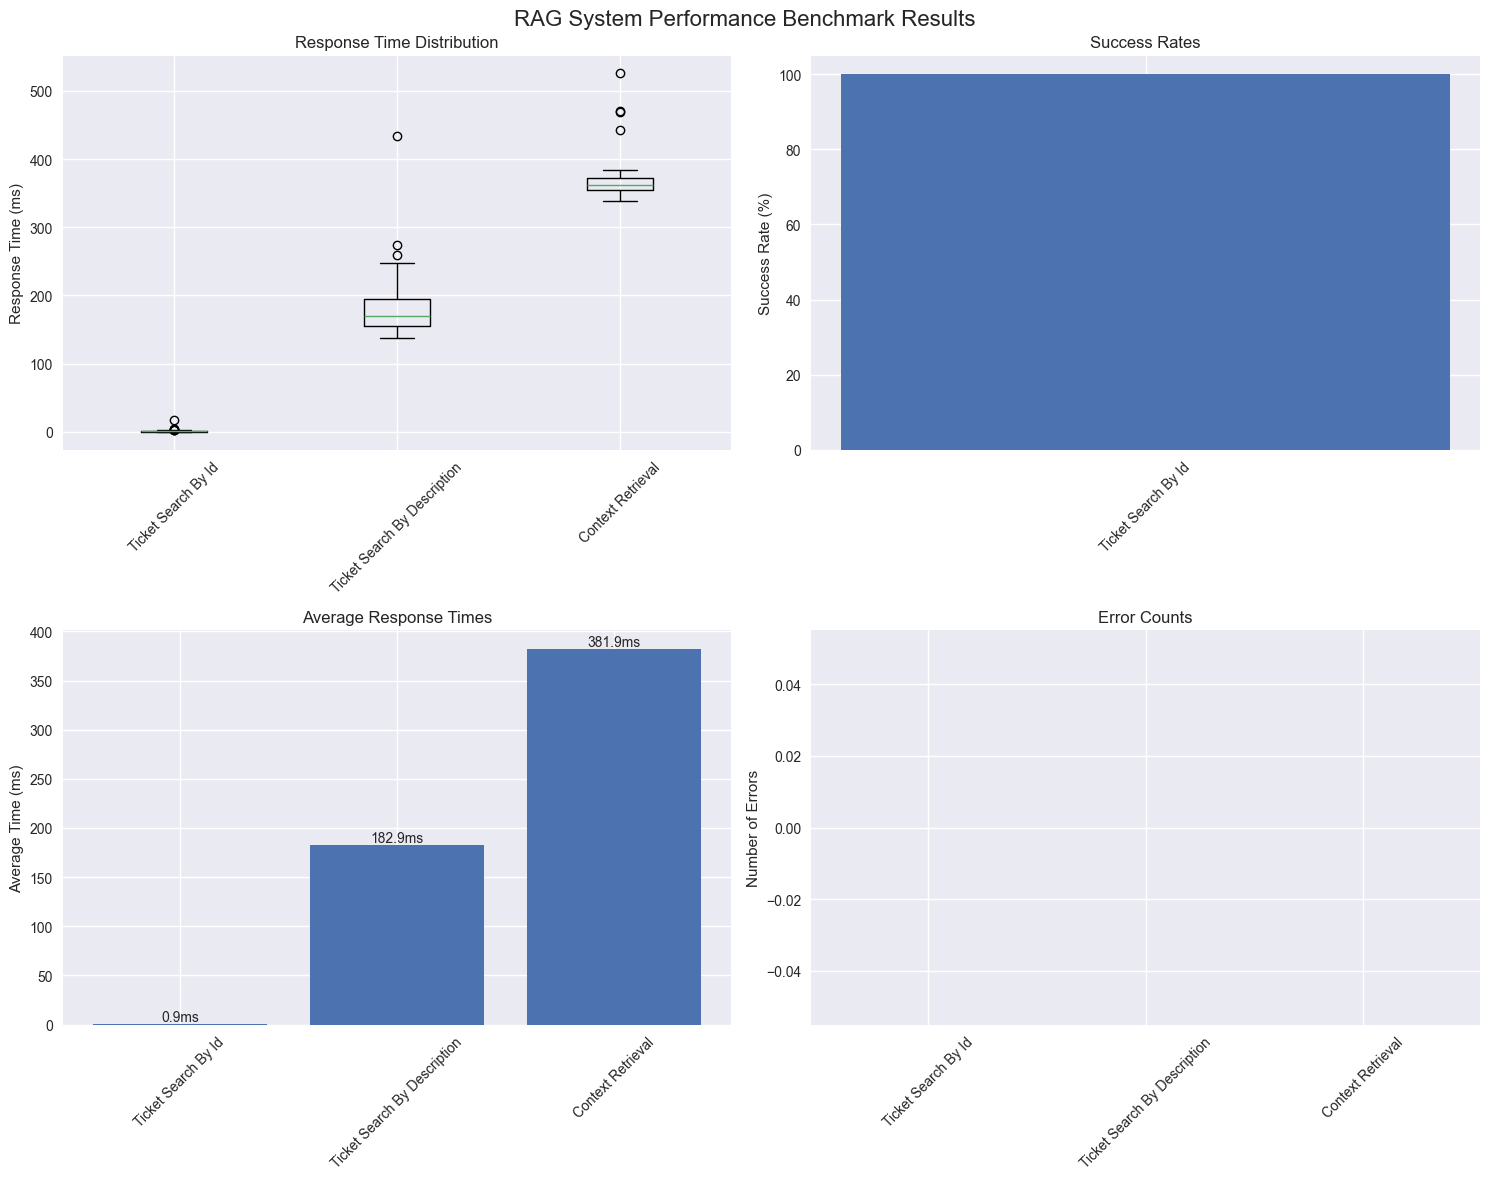

In [ ]:
# run_benchmark()